# Probability
*All models are wrong, but some are useful*

### Probabilistic Model
Recall that Percy uses a probabilistic model in contrast to a categorical one. Now that we've gathered a nameset let's explore how this is implemented.


In [3]:
# Loading our KeywordProcessor from the previous notebook
import pickle
with open(r'data/keyword_processor.pkl', 'rb') as fp:
    kp = pickle.load(fp)
    
names = kp.get_all_keywords()

For our purposes, each name can have two possible outcomes: male or female.

Therefore, we expect that the probability distribution will be a [Binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution). Note that we will use the convention of 0 == male and 1 == female going forward

We can easily calculate the probability of a person with a name being female in the below function

$P(f) = n_{female}/(n_{female} + n_{male})$

A Python implementation is below

In [30]:
def get_prob_female(name, kp=kp):
    n_male, n_female = max(kp.extract_keywords(name), key=lambda x: sum(x))
    return n_female / (n_male + n_female)
    
print(get_prob_female("John"))
print(get_prob_female("Mary"))


0.004450805850750951
0.995639936876698


While this calculation is simple, it makes some overreaching assumptions. Namely, is assumes that we have sampled every "John" and every "Mary". In fact, according to the SSA, this is exactly the case. So why is this a problem?

There is an incredible amount of diversity in the world's first names. Further the United States only represents roughly 5% of the world's population. So chances are for any given name, we will not have it in our database. Additionally, even if a name is present in our dataset, it only represents gender counts in the United States. Therefore, we cannot assume that our data is canonical!


### An Intuitive Approach
Sometimes it is useful to examine the extreme cases in our data to determine how we should proceed.

While we've determined that our name data is not entirely representative, surely this must lie on a spectrum. Some examples:          

| Name  | N_Male    | N_Female | Total     | % Female |
|-------|-----------|----------|-----------|----------|
| James | 1,335,487 | 6,918    | 1,342,405 | 0.51%    |
| Jey   | 5         | 0        | 5         | 0%       |
| Jenis | 0         | 5        | 5         | 100%     |

If we use our 'simple' calculation, we can see where this breaks down with small record sizes.
However, when the number of samples is sufficiently large, the calculation appears to be sensible.

What is needed is a method to convey our certainty in our probability calculation. This is where we can introduce

### The Bayesian Approach
![Bayesian](https://imgs.xkcd.com/comics/modified_bayes_theorem.png)

By fitting a [Beta-binomial distribution](https://en.wikipedia.org/wiki/Beta-binomial_distribution) to our name counts we could then convey our confidence in our probability calculation using a density interval.

Let's see how this looks for different sample sizes 


Min Probability : 1.2579%, Max Probability : 84.1886%
Min Probability : 9.4299%, Max Probability : 90.5701%
Min Probability : 0.2299%, Max Probability : 28.4914%
Min Probability : 29.7807%, Max Probability : 70.2193%
Min Probability : 26.2884%, Max Probability : 41.2268%
Min Probability : 0.5444%, Max Probability : 1.8115%
Min Probability : 1.8775%, Max Probability : 2.0477%


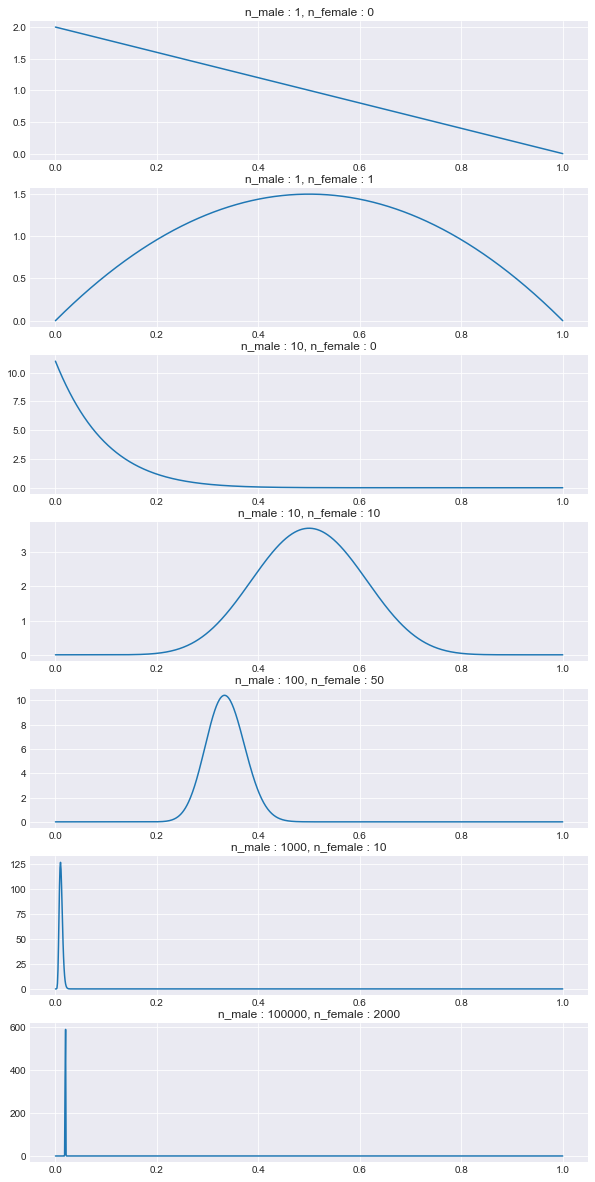

In [51]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline

from scipy import stats
import numpy as np

name_counts = [(1, 0),
               (1, 1),
               (10, 0),
               (10, 10),
               (100, 50),
               (1000, 10),
               (100000, 2000)]
                
def make_beta(n_male, n_female):
    
    n_male += 1
    n_female += 1
    return stats.beta(n_female, n_male)

x = np.linspace(0, 1, 1000)

pdf = []
prob_intervals = []

for n_male, n_female in name_counts:
    name_beta = make_beta(n_male, n_female)
    pdf.append(name_beta.pdf(x))
    prob_intervals.append(name_beta.interval(0.95))
    
f, axes = plt.subplots(len(name_counts), 1, figsize=(10,(3 *len(name_counts))))

for i, pdf_data in enumerate(pdf):
    axes[i].plot(x, pdf_data)
    axes[i].set_title("n_male : {}, n_female : {}".format(*name_counts[i]))
    
    print("Min Probability : {:.4%}, Max Probability : {:.4%}".format(*prob_intervals[i]))

Clearly we can see that as our sample size increases, our density interval decreases
  